In [ ]:
# %cd notebooks

In [2]:
import matplotlib.backends
import torch
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import cartopy.crs as ccrs 
import matplotlib 
from tqdm.notebook import tqdm
from models.model import CNNQuantilesClassifier, CNNQuantilesClassifierDepthWise
from models.data import load_output_data, load_input_data, get_rain_bool, xarray_to_dataloaders
from models.training import train_loop, eval_loop, evaluate_model

from captum.attr import Occlusion, IntegratedGradients


plt.style.use('robin')


In [3]:
%matplotlib inline

In [4]:

ds_ml= xr.open_dataset('/Data/gfi/users/rogui7909/era5_rain_norge/DL_era5_rain_regression_in_out.nc').sel(mask_id=[14]).sel(time=slice(None,'2021'))
ds_ml = ds_ml.where(ds_ml.data_in.count(['longitude', 'latitude']).sum('var_name')==24576, drop=True)


class Wang2024(nn.Module):
    def __init__(self, num_classes,num_channels_in, image_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1, groups=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=48, kernel_size=3, stride=1, padding=1, groups=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        cnn_channels = 48
        max_pools = 4*4
        self.linear_size = image_size * cnn_channels // max_pools 
        self.fc1 = nn.Linear(self.linear_size, 96)
        self.fc2 = nn.Linear(96, 48)
        self.fc3 = nn.Linear(48, num_classes)

    def forward(self, x):
        # print(x)
        x = self.conv1(x)
        x = nn.ReLU()(x)
        # print(x)
        x = self.pool1(x)
        # print(x)
        x = self.conv2(x)
        # print(x)
        x = nn.ReLU()(x)
        x = self.pool2(x)
        # print(x)
        x = x.view((-1,self.linear_size))
        # print(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = nn.Dropout()(x)

        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = nn.Dropout()(x)

        x = self.fc3(x)
        # x = nn.ReLU()(x)
        
        return x
    

In [5]:
device ='cuda:1'
model = Wang2024(num_classes=1, num_channels_in=3, image_size=128*64).to(device)
model.load_state_dict(torch.load('trained_models/wang2024_ERA5_norwaeyW_precip.torch', weights_only=True))
model.eval()

Wang2024(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=24576, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=48, bias=True)
  (fc3): Linear(in_features=48, out_features=1, bias=True)
)

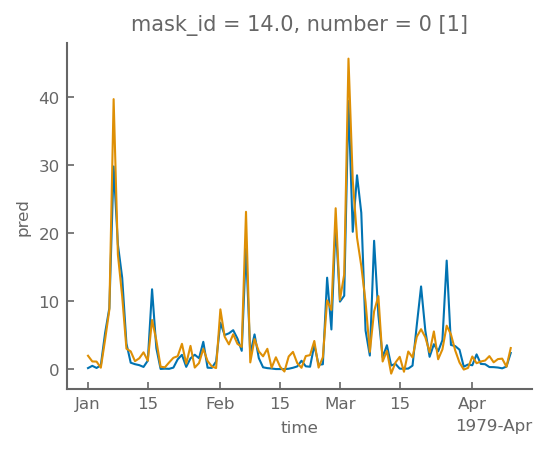

In [6]:

model.eval()
with torch.no_grad():
    model = model.cpu()
    data_in = ds_ml.data_in.values.squeeze()
    X = torch.tensor(data_in).type(torch.float32)
    pred = model(X).detach().numpy()

    pred_ds = xr.DataArray(pred, dims = ['time','mask_id'], coords=ds_ml.data_out.coords)
    ds_eval = xr.Dataset(dict(truth=ds_ml.data_out, pred=pred_ds)).sortby('time')

# ds_eval_destandard = ds_eval*ds_ml_std + ds_ml_mean
# ds_eval_destandard = np.exp(ds_eval) + 1e-5
ds_eval.truth.isel(time=slice(0,100)).plot()
ds_eval.pred.isel(time=slice(0,100)).plot()
plt.show()


Text(0.5, 1.0, 'Reliability diagram\nr=0.997')

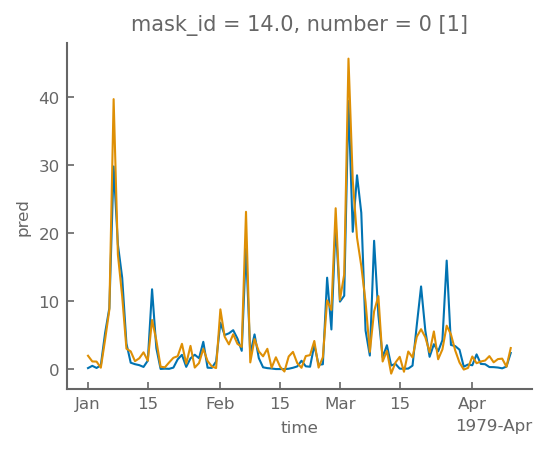

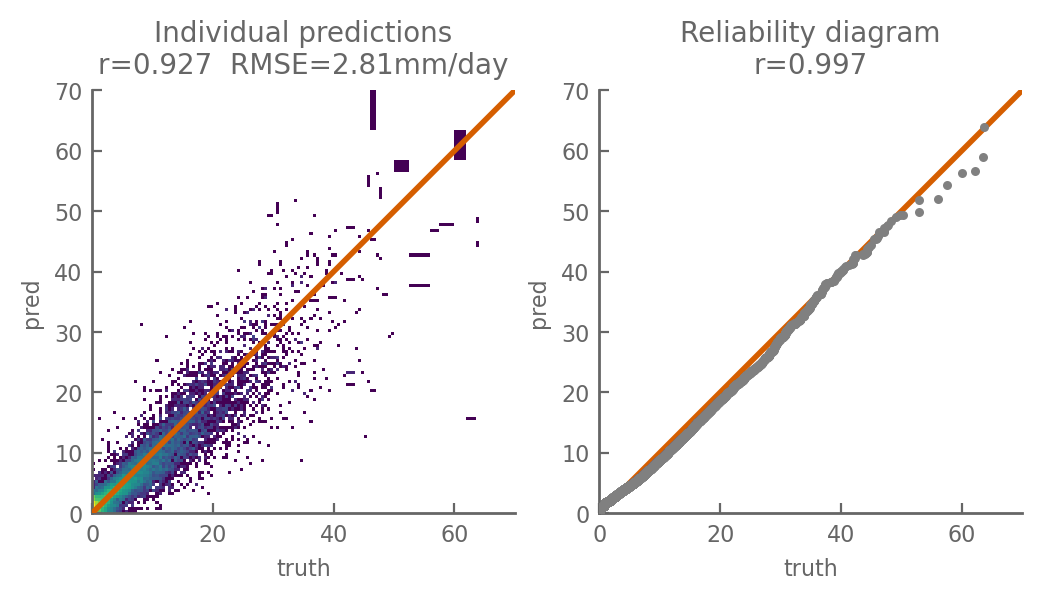

In [7]:
plt.figure()
ds_eval.truth.isel(time=slice(0,100)).plot()
ds_eval.pred.isel(time=slice(0,100)).plot()



import seaborn.objects as so
df_ = ds_eval.to_dataframe()
ds_bins = df_.groupby([pd.cut(df_.truth, np.arange(0,71,.5)),
             pd.cut(df_.pred, np.arange(0,71,.5)),
             ], observed=True).count().truth.to_xarray()

from matplotlib.colors import LogNorm

norm =  LogNorm(vmin=1, vmax=ds_bins.max())
fig, axs =plt.subplots(1,2,figsize=(6,3), dpi=200)
ds_bins.where(ds_bins>0).T.plot(norm = norm, ax=axs[0], add_colorbar=False)

sorted_df_ = df_.transform(np.sort)
sorted_df_.plot.scatter(y='pred',x='truth', ax=axs[1], s=5, color='.5', zorder=100)
for ax in axs:
    ax.set_aspect('equal')
    ax.set(xlim=(0,70), ylim=(0,70))
    ax.axline((0,0), slope=1, zorder=8, color='C3', lw=2)

axs[0].set_title(f"Individual predictions\nr={df_.corr().truth.pred:.03f}  RMSE={np.sqrt(((df_.truth - df_.pred)**2).mean()):.02f}mm/day")
axs[1].set_title(f"Reliability diagram\nr={sorted_df_.corr().truth.pred:.03f}")

# Percentiles

In [24]:
from captum.attr import LRP,DeepLiftShap, Occlusion,IntegratedGradients,NoiseTunnel

lrp = LRP(model.to('cpu'))
dlShap =  DeepLiftShap(model.to('cpu'))
ig = IntegratedGradients(model.to('cpu'))
nt = NoiseTunnel(ig)
occ = Occlusion(model.to('cpu'))

In [9]:
ds_rain30 = ds_ml.sel(time = df_.query("pred>30&truth>30").index.get_level_values(0)) # 30 is approx 99 percentile

In [30]:
input_tensor = torch.Tensor(ds_rain30.data_in.values).to('cpu')
baseline = torch.zeros_like(input_tensor)
# attrs_lrp = xr.DataArray(lrp.attribute(input_tensor, rule=).detach().numpy(), dims=ds_rain30.data_in.dims, coords=ds_rain30.data_in.coords)
# attrs_ig = xr.DataArray(ig.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_rain30.data_in.dims, coords=ds_rain30.data_in.coords)
# attrs_nt = xr.DataArray(nt.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_rain30.data_in.dims, coords=ds_rain30.data_in.coords)
attrs_occ = xr.DataArray(occ.attribute(input_tensor, baselines=baseline,sliding_window_shapes=(1,5,5), strides=(1,3,3)).detach().numpy(), dims=ds_rain30.data_in.dims, coords=ds_rain30.data_in.coords)
# attrs_dls = xr.DataArray(dlShap.attribute(input_tensor, baselines=baseline).detach().numpy(), dims=ds_rain30.data_in.dims, coords=ds_rain30.data_in.coords)


In [55]:
import shap

In [64]:
ds_ml.data_out//10

<xarray.DataArray 'data_out' (time: 15675, mask_id: 1)> Size: 125kB
array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [2.],
       [1.]])
Coordinates:
  * time     (time) datetime64[ns] 125kB 1979-01-01 1979-01-02 ... 2021-12-31
  * mask_id  (mask_id) float64 8B 14.0
    number   int64 8B 0

In [ ]:
shap_values = shap_values[0].reshape(-1, 128*64)
X_test = input_tensor.reshape(-1, 128*64)

shap.summary_plot(shap_values, X_test)

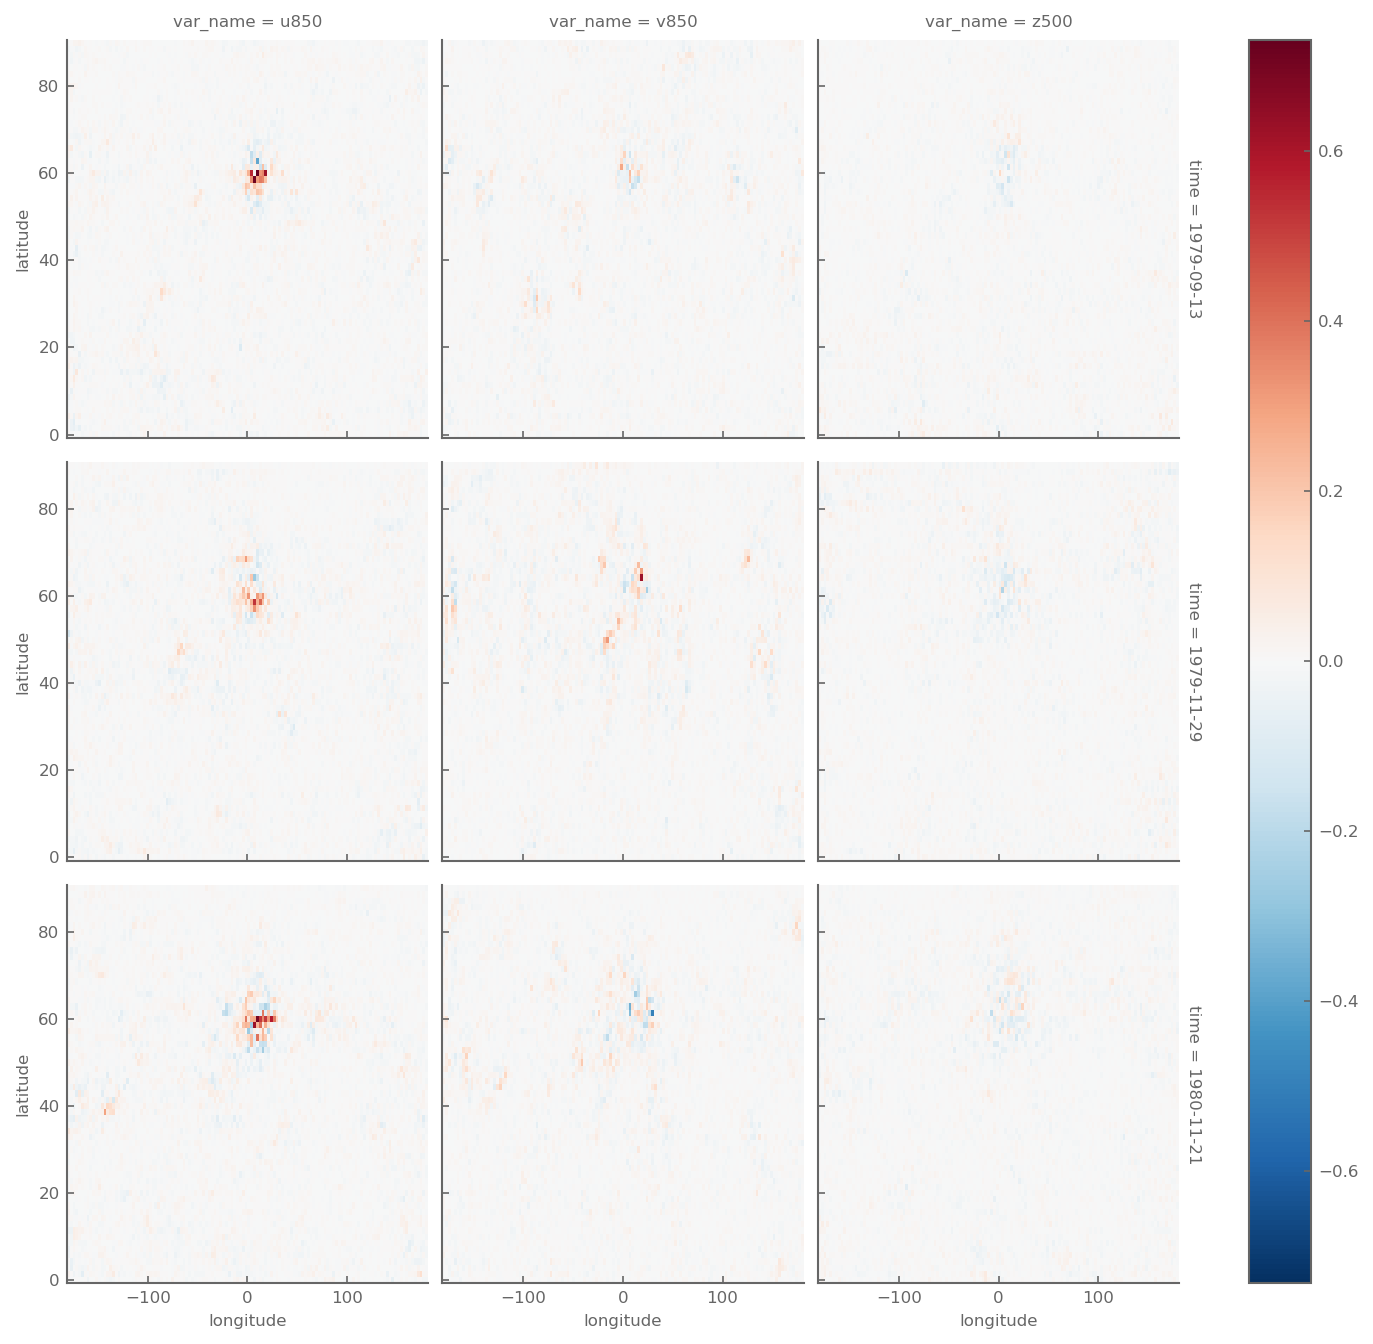

In [54]:
attrs_nt.isel(time=[1,2,3]).plot(col='var_name', row='time')